![logo](../../picture/license_header_logo.png)
> **Copyright (c) 2020-2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program is part of OSRFramework. You can redistribute it and/or modify
<br>it under the terms of the GNU Affero General Public License as published by
<br>the Free Software Foundation, either version 3 of the License, or
<br>(at your option) any later version.
<br>
<br>This program is distributed in the hope that it will be useful,
<br>but WITHOUT ANY WARRANTY; without even the implied warranty of
<br>MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
<br>GNU Affero General Public License for more details.
<br>
<br>You should have received a copy of the GNU Affero General Public License
<br>along with this program.  If not, see <http://www.gnu.org/licenses/>.
<br>

# 03 - Time Series Forecasting Using Multilayer Perceptron (MLP)

Authored by: [Kian Yang Lee](https://github.com/KianYang-Lee) - kianyang.lee@certifai.ai

## Notebook Description
This tutorial will showcase the usage of multilayer perceptron (MLP) in time series forecasting. The deep learning framework used here is PyTorch. An exercise section is attached for you to practice and hone your skills. Do make good use of it.

By the end of this tutorial, you will be able to:

1. Prepare dataset to be feed into MLP model
2. Build and apply MLP model to perform forecasting
3. Compare and contrast performance of MLP model

## Notebook Outline
Below is the outline for this tutorial:
1. [Notebook Configurations](#configuration)
2. [Dataset](#dataset)
3. [Basic Analytics](#analytics)
4. [Model Development](#model-dev)
5. [Evaluation](#evaluation)
6. [Exercise](#exercise)
7. [Reference](#reference)
8. [Bonus](#bonus)

## <a name="configuration">Notebook Configurations</a>
Following are the modules that will be used for this tutorial. This notebook will heavily use `torch` as they provide great APIs when for building deep learning models. You can find out more about them [here](https://pytorch.org/).

In [1]:
# Importing libraries
import sys
from datetime import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
from sklearn.metrics import mean_squared_error

# seed configuration
np.random.seed(38)
torch.manual_seed(38)

## <a name="dataset">Dataset</a>
We would be using the a time series data containing monthly shampoo sales for this exercise. It is a famous and commonly used dataset for time series forecasting practice. We will split the data into training and test dataset.

In [2]:
# path specification
dataset_dir_path = Path().resolve().parent.parent/'datasets'
data_dir_path = dataset_dir_path/'others'
training_file_name = 'shampoo-sales.csv' 

# import dataset
df_shampoo = pd.read_csv(data_dir_path/training_file_name)

## <a name="analytics">Basic Analytics</a>
Let's do some basic analytics and see what nugget can we find out of the training dataset! Let first find out the number of rows and columns of the training dataset.

**Note: Since we are not supposed to know any information about the test dataset, we will not perform any analytics on it.**

In [3]:
# inspect first 15 rows of data
df_shampoo.head(15)

,month,sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3
5,1-06,168.5
6,1-07,231.8
7,1-08,224.5
8,1-09,192.8
9,1-10,122.9


We can see that there are two columns, month and sales. Let's also inspect the data type for each column.

In [4]:
# compute dtype
for column in df_shampoo.columns:
    print(f"The data type for '{column}' column is: {df_shampoo[column].dtype}")

The data type for 'month' column is: object
The data type for 'sales' column is: float64


Now, we will compute the descriptive statistics.

In [5]:
# compute descriptive statistics
df_shampoo.describe()

,sales
count,36.000000
mean,312.600000
std,148.937164
min,119.300000
25%,192.450000
50%,280.150000
75%,411.100000
max,682.000000


The descriptive statistics computed are the mean, standard deviation, minimum and maximum values. We see that the maximum value is 682.00 and minimum value is 119.30, and the standard deviation is 148.94. This shows that the sales volume varies by a large spread. Next, we will plot a time plot for the data.

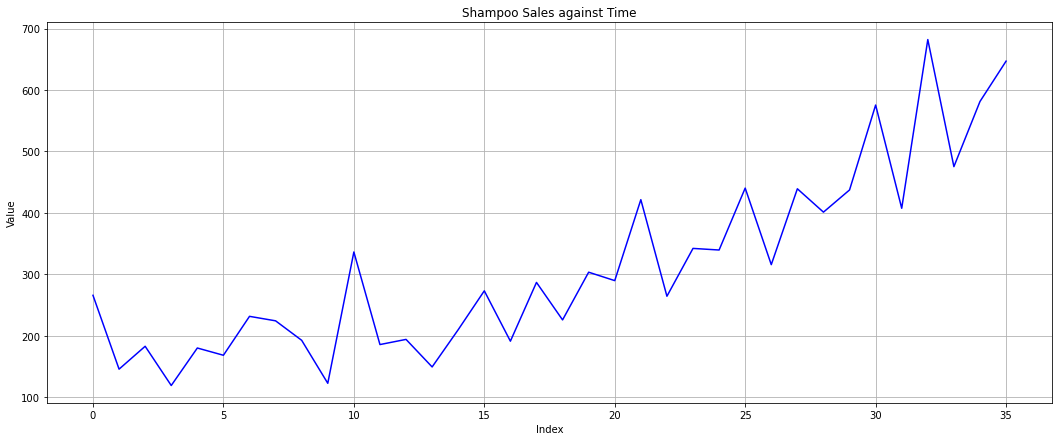

In [6]:
# plot time plot 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Shampoo Sales against Time")
ax.grid(b=True)
ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.plot(
    df_shampoo['sales'],
    color='blue', label='Data');

Now that we get to feel the ebb and flow of the data. Let's split the dataset into training and test set.

In [7]:
# split dataset
df_train, df_test = train_test_split(df_shampoo, train_size=0.7, shuffle=False)

# display training dataset length
print(f"The length of training dataset is: {len(df_train)}")

# display test dataset length
print(f"The length of test dataset is: {len(df_test)}")

The length of training dataset is: 25
The length of test dataset is: 11


Let's see what are the portion of dataset which is splitted as training dataset and test dataset.

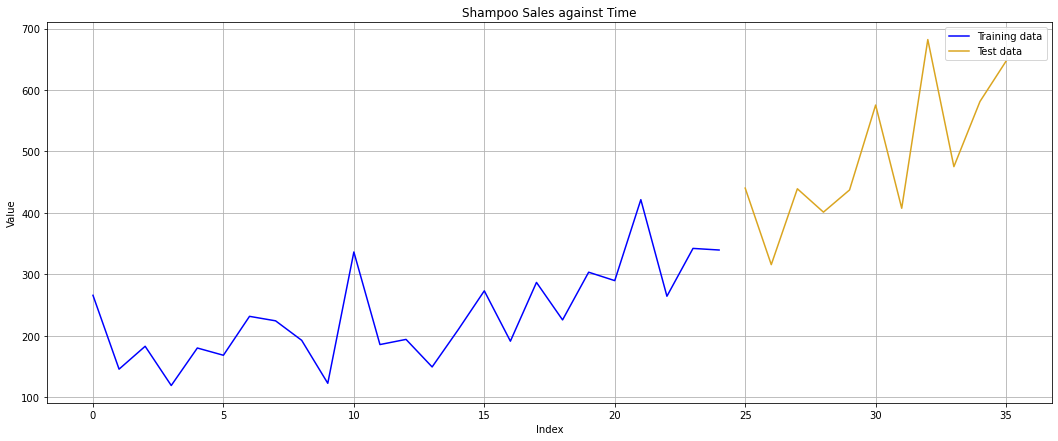

In [8]:
# plot time plot for training and test dataset 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Shampoo Sales against Time")
ax.grid(b=True)
ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.plot(
    df_train['sales'],
    color='blue', label='Training data');
ax.plot(
    df_test['sales'],
    color='goldenrod', label='Test data')
ax.legend();

Feature scalinng also help in shortening model training time. Let's do that too.

In [9]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(df_train['sales'].values.reshape(-1,1))
test_scaled = scaler.transform(df_test['sales'].values.reshape(-1,1))

## <a name="model-dev">Model Development</a>
The `torch` library provides a number of API to easily construct a MLP model for the tasks at hand. But first, we will need to prepare the dataset into a format ingestible by the model first. We will first transform the time series data into feature of label, where the feature would be a sequence of *n* length of data and label would be lead-1 of the last data in the feature.

In [10]:
# write a helper function which slices through the features using the sequence_length parameter and index the labe at the time step
# function should return features in sequence and labels
def sequencing_data(data, sequence_length):
    """
    Helper function to sample sub-sequence of training data.
    Input data must be in np.ndarray.
    """
    x, y = [], []

    for i in range(data.shape[0] - sequence_length):

        # copy the sequences of data starting at this index
        x.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return x, y

# calling the helper function and store them in variables
X_sequence_train, y_sequence_train = sequencing_data(train_scaled, 3)
X_sequence_test, y_sequence_test = sequencing_data(test_scaled, 3)

# sanity check 
print("Total samples for X train: " + str(len(X_sequence_train)))
print("Total samples for y train: " + str(len(y_sequence_train)))
print("Total samples for X test: " + str(len(X_sequence_test)))
print("Total samples for y test: " + str(len(y_sequence_test)))

Total samples for X train: 22
Total samples for y train: 22
Total samples for X test: 8
Total samples for y test: 8


Let's write a custom `Dataset` class to transfrom the data into tuples of `torch.Tensor`. This is necessary if we want to load the data in batches using `DataLoader`.

In [11]:
class ShampooDataset(Dataset):
    """
    Convert input data into torch FloatTensor. 
    Inherit Dataset class. Return length of instance when len method is called and return specific sample
    of data when indexed.
    """ 
    def __init__(self, x, y):
        self.x = torch.FloatTensor(x)
        self.y = torch.FloatTensor(y)
        
    def __len__(self):
        return self.x.size(0)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

We will write the codes to convert data into `Dataset` object and then into `DataLoader` object. We will be using a batch size of 4 for this `DataLoader` object.

In [12]:
# declare batch size
batch_size = 4

# convert into Dataset using customized class
train_Dataset = ShampooDataset(X_sequence_train, y_sequence_train)
test_Dataset = ShampooDataset(X_sequence_test, y_sequence_test)

# convert into DataLoader
train_loader = DataLoader(train_Dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_Dataset, batch_size=batch_size, shuffle=False)

# declare a dict object
dataloaders = {'train': train_loader, 'test': test_loader} 

It's about time to declare our MLP model architecture. The following code demonstrates how to build a simple MLP model.

In [13]:
class MLP(nn.Module):
    """MLP model with configurable input size and output size."""
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.input = nn.Linear(input_size, 64)
        self.linear1 = nn.Linear(64, 16)
        self.output = nn.Linear(16, output_size)
    
    def forward(self, x):
        x = x.view(-1, 1, 3)
        out = F.relu(self.input(x))
        out = F.relu(self.linear1(out))
        out = self.output(out)
        return out

Before we can start our training, we also need to configure some hyperparameters. Let's do that.

In [14]:
# reproducibility
torch.manual_seed(38)

# setting hyperparameter
input_size = 3
output_size = 1
epochs = 100
learning_rate = 0.001

# instantiate the model
model = MLP(input_size, output_size)

# continue setting hyperparameter
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

We can perform our model training now. In `torch`, we need to manually write codes to implement model training.

In [15]:
# implement model training and validation loop
loss_score = {'train': [], 'test': []}
for epoch in range(epochs):
#     print(f'Epoch {epoch+1}/{epochs}')
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        loss_cumsum = 0.0
        total_iterations = 0.0

        for i, (X, y) in enumerate(dataloaders[phase]):
            with torch.set_grad_enabled(phase == 'train'):
                out = model(X)
                loss = criterion(out.squeeze(), y.squeeze())

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            loss_cumsum += loss.item() * out.size(0)
            total_iterations += out.size(0)

        epoch_loss = loss_cumsum / total_iterations
#         print(f'{phase.upper()} Loss: {epoch_loss}')
        loss_score[phase].append(epoch_loss)


We can plot the loss score to check how is the model performing when trained by epochs.

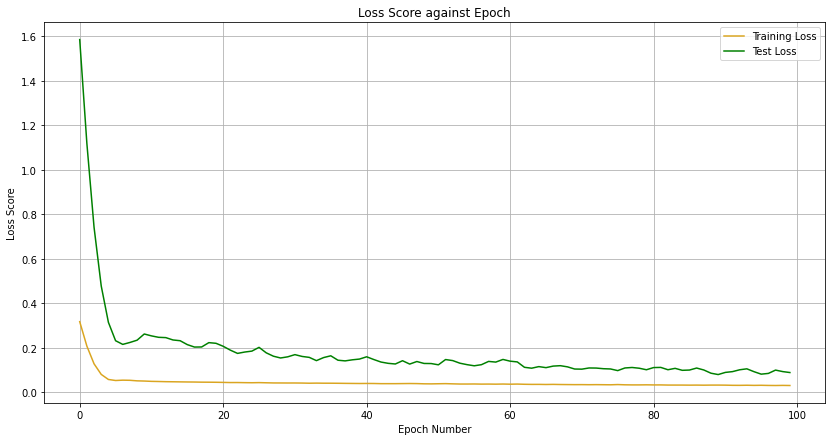

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
ax.set_title("Loss Score against Epoch")
ax.grid(b=True)
ax.set_xlabel("Epoch Number")
ax.set_ylabel("Loss Score")

ax.plot(loss_score['train'], color='goldenrod', label='Training Loss')
ax.plot(loss_score['test'], color='green', label='Test Loss')
ax.legend();

## <a name="evaluation">Evaluation</a>
There are a few metrics that can be used to evaluate the performance of a regression model, which include:
* mean squared error (MSE)
* root mean squared error (RMSE)
* mean absolute error (MAE)

We will examine the performance of the model on test set using RMSE. 

In [17]:
model.eval()

predictions = []
count = 0

# model predictions
with torch.no_grad():
    for i, (X, y) in enumerate(DataLoader(test_Dataset, 1)):
        count += 1
        output = model(X)
        predictions.append(output.item())
        
# convert list into np array and inverse transform it into proper values before feature scaling
predictions = np.array(predictions)
predictions = scaler.inverse_transform(predictions.reshape(1,-1))

# remove beginning 3 rows of data since at least 3 data are needed to make a prediction
df_test = df_test.iloc[3:]
df_test['preds'] = predictions.squeeze()

# compute MSE
RMSE = mean_squared_error(df_test.preds, df_test.sales, squared=False)
print(f"The RMSE for the model is {RMSE}")

The RMSE for the model is 89.80567585554041


We can also print and visualize predictions made by the model for inspection purpose.

28    361.567907
29    425.134434
30    432.216779
31    467.946748
32    525.088371
33    476.364588
34    581.250400
35    528.590299
Name: preds, dtype: float64


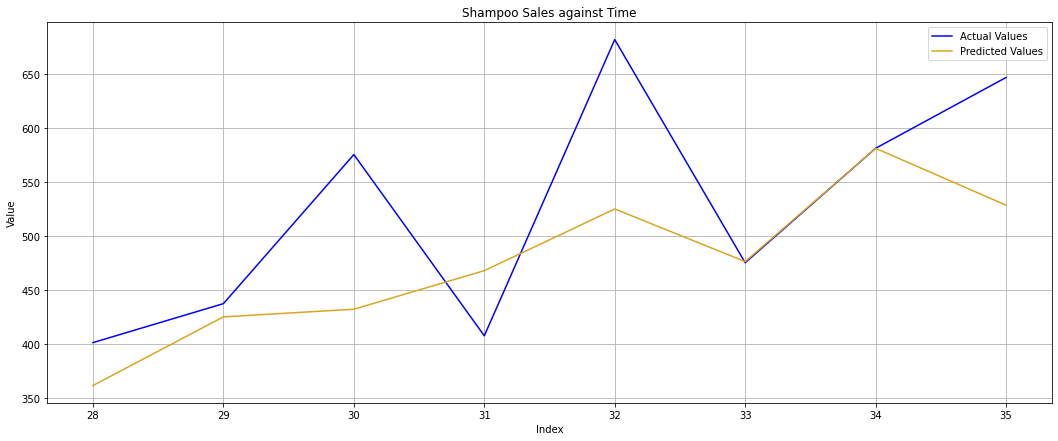

In [18]:
print(df_test['preds'])

# plot time plot for predictions and ground truth 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Shampoo Sales against Time")
ax.grid(b=True)
ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.plot(
    df_test['sales'],
    color='blue', label='Actual Values');
ax.plot(
    df_test['preds'],
    color='goldenrod', label='Predicted Values')
ax.legend();

## <a name="exercise">Exercise</a>

This exercise section is attached for you to practice and hone your skills. Try your best effort to complete it without referring to the solution.

### Notebook Configurations
You can import any module that you wish to use for this exercise. However, if you run the cells from the start of this notebook, most probably all the modules which you need had already been imported at this point.

In [19]:
# import modules
### BEGIN SOLUTION


### END SOLUTION

### Dataset
**INSTRUCTIONS**: Please perform time series forecasting using MLP on furniture-sales.csv dataset. You can locate the file in the `datasets` folder.

In [20]:
# path specification
### BEGIN SOLUTION



### END SOLUTION

# import dataset
### BEGIN SOLUTION

### END SOLUTION

### Basic Analytics
**INSTRUCTIONS**: Perform some basic analytics on the dataset by following the guidelines that are provided in each cell.

In [21]:
# inspect first 15 rows of data
### BEGIN SOLUTION

### END SOLUTION

In [22]:
# compute dtype
### BEGIN SOLUTION


### END SOLUTION

In [23]:
# rename column to 'Date' and 'Sales'
### BEGIN SOLUTION

### END SOLUTION

# compute descriptive statistics
### BEGIN SOLUTION

### END SOLUTION

In [24]:
# plot time plot 
### BEGIN SOLUTION








### END SOLUTION

In [25]:
# split dataset into 7:3 of train:test set from the whole dataset
### BEGIN SOLUTION
df_train, df_test = None, None
### END SOLUTION

In [26]:
# plot time plot for training and test dataset 
### BEGIN SOLUTION










### END SOLUTION

In [27]:
# feature scaling using min-max normalization
### BEGIN SOLUTION



### END SOLUTION

### Model Development
**INSTRUCTIONS**: Build and develop a MLP model using training dataset.

In [28]:
# write a helper function which slices through the features using the sequence_length parameter and index the labe at the time step
# function should return features in sequence and labels
def sequencing_data(data, sequence_length):
    """
    Helper function to sample sub-sequence of training data.
    Input data must be in np.ndarray.
    """
    ### BEGIN SOLUTION
    x = None
    y = None
    
    
    
    
    
    ### END SOLUTION
    return x, y

# calling the helper function and store them in variables
### BEGIN SOLUTION


### END SOLUTION

In [29]:
# write custom Dataset to transform list object into Dataset object
class FurnitureDataset(Dataset):
    """
    Convert input data into torch FloatTensor. 
    Inherit Dataset class. Return length of instance when len method is called and return specific sample
    of data when indexed.
    """ 
    ### BEGIN SOLUTION

    
    
    
    
    
    
    ### END SOLUTION

In [30]:
# declare batch size
### BEGIN SOLUTION
batch_size = None
### END SOLUTION

# convert into Dataset using customized class
### BEGIN SOLUTION


### END SOLUTION

# convert into DataLoader
### BEGIN SOLUTION


### END SOLUTION

# declare a dict object
### BEGIN SOLUTION

### END SOLUTION

In [31]:
# define MLP model architecture
class MLP(nn.Module):
    """MLP model with configurable input size and output size."""
    ### BEGIN SOLUTION

    
    
    
    
    
    
    
    
    ### END SOLUTION

In [32]:
# setting hyperparameter
### BEGIN SOLUTION
input_size = None
output_size = None
epochs = None
learning_rate = None
### END SOLUTION

# instantiate the model
### BEGIN SOLUTION

### END SOLUTION

# continue setting hyperparameter
### BEGIN SOLUTION


### END SOLUTION

In [33]:
# implement model training and validation loop
### BEGIN SOLUTION














### END SOLUTION

In [34]:
# plot loss scores
### BEGIN SOLUTION









### END SOLUTION

### Evaluation
**INSTRUCTIONS:** Follow the guidelines given in the cells to evaluate performance of model.

In [35]:
# model predictions
### BEGIN SOLUTION








### END SOLUTION
        
# convert list into np array and inverse transform it into proper values before feature scaling
### BEGIN SOLUTION


### END SOLUTION

# remove beginning 7 rows of data since at least 7 data are needed to make a prediction
### BEGIN SOLUTION


### END SOLUTION

# compute MSE
### BEGIN SOLUTION


### END SOLUTION

In [36]:
# print prediction results
### BEGIN SOLUTION

### END SOLUTION

# plot time plot for predictions and ground truth 
### BEGIN SOLUTION












### END SOLUTION

## <a name="reference">Reference</a>
1. [Pytorch](https://pytorch.org/)

## <a name="bonus">Bonus</a>

The first neural network to be applied to a real-world problem is MADALINE, which stands for Multiple ADAptive LINear Elements. It was developed by Bernard Widrow and Marcian Hoff of Stanfor from 1959.

Source: [3.0 History of Neural Networks](http://www2.psych.utoronto.ca/users/reingold/courses/ai/cache/neural4.html#:~:text=In%201959%2C%20Bernard%20Widrow%20and,to%20a%20real%20world%20problem.)